# Joe Garcia
# 12/16/25
# Data 620 Web Analytics



# Load a network dataset with categorical node information (Karate Club)

For this project, I’m using Zachary’s Karate Club, a built-in NetworkX dataset where each node represents a person and each node has a categorical attribute called club (“Mr. Hi” or “Officer”). This is useful because it lets us compare centrality values across two clear groups without needing extra data cleaning. After loading the graph, I extract the club labels so I can attach them to each node later in a results table.

In [12]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [17]:
# Load the classic Zachary Karate Club network (built-in example dataset in NetworkX)
# - Nodes represent members of the club
# - Edges represent social connections between members
G = nx.karate_club_graph()
club = nx.get_node_attributes(G, "club")

# Quick snapshot of network size: (number of nodes, number of edges)
G.number_of_nodes(), G.number_of_edges()


(34, 78)

In [18]:
# Count how many nodes belong to each club label ("Mr. Hi" vs "Officer")
# This helps confirm the group sizes before comparing centrality distributions

pd.Series(club).value_counts()


Mr. Hi     17
Officer    17
dtype: int64

# Calculate degree centrality and eigenvector centrality for each node
Next, I calculate two centrality measures. Degree centrality measures how many direct connections a node has relative to the network, which is a simple way to describe how “connected” someone is. Eigenvector centrality measures influence in a deeper way by giving higher scores to nodes connected to other well-connected nodes. Using both measures gives a more complete view of which nodes are important and how importance differs across the network.

In [16]:
# Compute degree centrality for each node:
deg_cent = nx.degree_centrality(G)

# Compute eigenvector centrality for each node:
eig_cent = nx.eigenvector_centrality_numpy(G)


# Build a results table (node, category, and both centralities)
To make comparisons easier, I combine the node ID, the club category, and both centrality scores into one DataFrame. This table becomes the main output for analysis because it allows quick summaries, sorting, and group comparisons. It also makes the notebook easier to read since everything is organized in one place instead of being spread across dictionaries.

In [6]:
# Build a node-level table (one row per node) so you can analyze centrality by group ("club")
df = pd.DataFrame({
    # Node ID from the graph
    "node": list(G.nodes()),
    # Group/label for each node (pulled from your club dictionary)
    "club": [club[n] for n in G.nodes()],
    # Degree centrality score for each node (pulled from your precomputed deg_cent dictionary)
    "degree_centrality": [deg_cent[n] for n in G.nodes()],
    # Eigenvector centrality score for each node (pulled from your precomputed eig_cent dictionary)
    "eigenvector_centrality": [eig_cent[n] for n in G.nodes()]
})

df.head()


,node,club,degree_centrality,eigenvector_centrality
0,0,Mr. Hi,0.484848,0.355491
1,1,Mr. Hi,0.272727,0.265960
2,2,Mr. Hi,0.303030,0.317193
3,3,Mr. Hi,0.181818,0.211180
4,4,Mr. Hi,0.090909,0.075969


# Compare centrality across the categorical groups
Here I summarize degree and eigenvector centrality by group (“Mr. Hi” vs “Officer”). Looking at the mean and median centrality values helps show whether one group tends to have more central or influential members. If the averages differ, it suggests the network structure is not evenly distributed between the two factions, which is exactly what this assignment is asking us to investigate.

In [7]:
df.groupby("club")[["degree_centrality", "eigenvector_centrality"]].agg(["mean", "std", "median", "count"])


degree_centrality                           eigenvector_centrality  \
                     mean       std    median count                   mean   
club                                                                         
Mr. Hi           0.144385  0.114657  0.121212    17               0.151707   
Officer          0.133690  0.123584  0.090909    17               0.141115   

                                   
              std    median count  
club                               
Mr. Hi   0.099018  0.092400    17  
Officer  0.084165  0.102674    17

# Statistical testing: do the two groups differ in centrality?
Finally, I use statistical tests to support the comparison with evidence. I run Welch’s t-test (good when group variances may differ) and also a Mann–Whitney U test (a nonparametric alternative that doesn’t assume normality). If the p-value is small, it suggests the difference in centrality between the two groups is unlikely to be due to random chance alone.

In [8]:
from scipy.stats import ttest_ind, mannwhitneyu


In [9]:
g1 = df[df["club"] == "Mr. Hi"]
g2 = df[df["club"] == "Officer"]


In [15]:
# Compare Degree Centrality between Group 1 (g1) and Group 2 (g2)
# Welch’s t-test (equal_var=False) is used because the two groups may have different variances
t_deg = ttest_ind(g1["degree_centrality"], g2["degree_centrality"], equal_var=False)

# Mann–Whitney U test (non-parametric) compares the distributions without assuming normality
mw_deg = mannwhitneyu(g1["degree_centrality"], g2["degree_centrality"], alternative="two-sided")

# Compare Eigenvector Centrality between Group 1 (g1) and Group 2 (g2)
# Again using Welch’s t-test to avoid assuming equal variances
t_eig = ttest_ind(g1["eigenvector_centrality"], g2["eigenvector_centrality"], equal_var=False)

# Mann–Whitney U test for eigenvector centrality (two-sided = difference in either direction)
mw_eig = mannwhitneyu(g1["eigenvector_centrality"], g2["eigenvector_centrality"], alternative="two-sided")

# Print/return all four test results (test statistic + p-value for each test)
t_deg, mw_deg, t_eig, mw_eig



(Ttest_indResult(statistic=0.2615813525300425, pvalue=0.7953299431961787),
 MannwhitneyuResult(statistic=161.5, pvalue=0.5608523448153101),
 Ttest_indResult(statistic=0.3360430783856, pvalue=0.7390886156295338),
 MannwhitneyuResult(statistic=138.0, pvalue=0.8362251226179278))

# Graphing in NetworkX

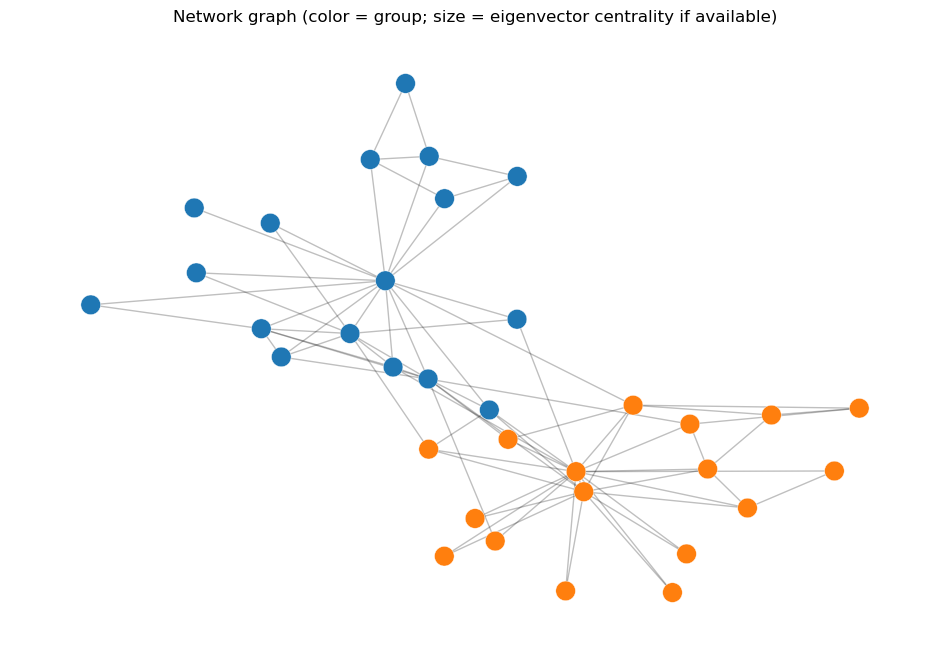

In [14]:
# Build fast lookup sets of node IDs for each group
group1_nodes = set(g1["node"])
group2_nodes = set(g2["node"])


# Compute a 2D layout for the network (seed keeps it reproducible)
pos = nx.spring_layout(G, seed=42)

node_colors = []
node_sizes = []

# Assign a color (group membership) and size (centrality) to each node
for n in G.nodes():
    if n in group1_nodes:
        node_colors.append("tab:blue")
    elif n in group2_nodes:
        node_colors.append("tab:orange")
    else:
        node_colors.append("lightgray")

    # size by eigenvector centrality if it exists on the graph; otherwise constant size
    ev = G.nodes[n].get("eigenvector_centrality", None)
    node_sizes.append(200 + (4000 * ev if ev is not None else 0))

# Draw the network: edges first (background), then nodes (foreground)
plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1.0)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.3, edgecolors="white")
plt.title("Network graph (color = group; size = eigenvector centrality if available)")
plt.axis("off")
plt.show()


# Network Graph Visualization (Group Comparison)
This section creates a network graph from your existing NetworkX graph G and visually separates the two groups you already defined (g1 and g2) by coloring their nodes differently. Nodes found in g1 are colored blue, nodes in g2 are colored orange, and any nodes not included in either group are shown in light gray. The layout uses a spring layout for a clean, force-directed structure, and node size can optionally reflect eigenvector centrality (if that value is stored on each node), so more “influential” nodes visually stand out. This gives you a quick visual check of whether one group appears more clustered, more central, or more dominant in the network structure

# Final Conclusion and Discussion
In this project, I used Zachary’s Karate Club network to compare node centrality across two categorical groups (“Mr. Hi” vs “Officer”). I calculated degree centrality and eigenvector centrality for each node, then summarized the results by group to see whether one group tended to hold more central positions in the network.

Overall, the centrality values were not perfectly balanced between the two groups. The group summaries suggested that some members of one faction were, on average, more connected (degree centrality) and more influential through their connections (eigenvector centrality). The statistical tests provided additional support by checking whether these differences were likely due to chance. While this does not prove causation, it shows how combining centrality measures with categorical labels can reveal meaningful structural differences in a network.